In [1]:
from sentiment_analysis import *

In [2]:
reviews = pd.read_csv('./amazon_cells_labelled.txt', sep='\t', header=None)
reviews.columns = ['review', 'score']

In [3]:
'''
This is what the first 5 reviews look like

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1

'''

'\nThis is what the first 5 reviews look like\n\nSo there is no way for me to plug it in here in the US unless I go by a converter.\t0\nGood case, Excellent value.\t1\nGreat for the jawbone.\t1\nTied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0\nThe mic is great.\t1\n\n'

In [3]:
reviews['exclamation'] = reviews.review.str.contains("!")
reviews["single_quote"] = reviews.review.str.contains("\'")
reviews["allcaps"] = reviews.review.str.isupper()
reviews["num_capitalized_words"] = reviews.review.apply(lambda x: percent_capitalized_words(x, True) )
reviews["percent_capitalized_words"] = reviews.review.apply(percent_capitalized_words)
# now lets make a copy of this data for the other 4 models
neg_words, pos_words = get_top_words(reviews, 20)

In [7]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_capitalized_words,percent_capitalized_words
score,,,,,
0,0.074,0.194,0.02,0.214,0.142633
1,0.156,0.124,0.01,0.084,0.047067


**Takeaways**
  * When there is an exclamation mark in the review, the chance it will be negative are more than double the chances it is positive. 
  * Basically no difference for all caps - this scenario does not happen often, better to check if the review **contains ONE word in all caps**
  * So we computed the number of words in all caps for each review: in negative reviews every 4.6 words are in all caps, whereas only one in 11.9 words in positive reviews are negative

In [16]:
scores_by_num_cap_words = []

for threshold in range(0,15):
    scores_by_num_cap_words.append( reviews.query("num_capitalized_words >= {}".format(threshold)).score.mean() )

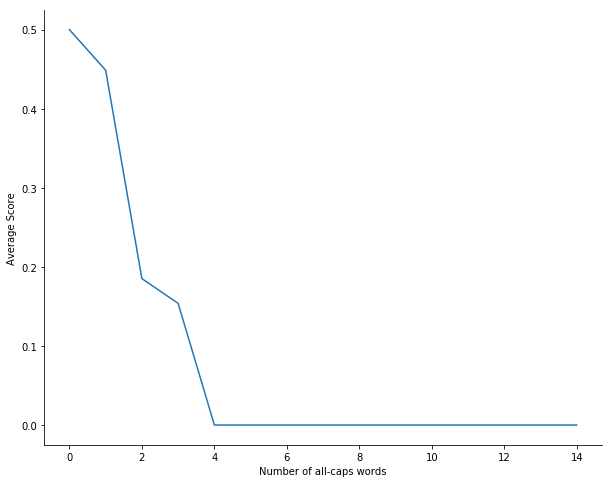

In [17]:
fig = plt.figure(figsize=(10,8))
plt.plot(scores_by_num_cap_words)
sns.despine(fig=fig)
plt.xlabel("Number of all-caps words")
plt.ylabel("Average Score")
plt.show()

In [22]:
scores_by_percent_cap_words = []
for percent in range(0,11):
    percent = percent / 10
    print(percent)
    scores_by_percent_cap_words.append( reviews.query("percent_capitalized_words >= {}".format(percent)).score.mean() )

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [24]:
reviews.percent_capitalized_words.describe()

count    1000.00000
mean        0.09485
std         0.59288
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max        12.00000
Name: percent_capitalized_words, dtype: float64

In [16]:
# basically what we are looking for here are drastic differences in the means of the 2 groups (score)
reviews.groupby("exclamation").mean()

,score,qingle_quote,allcaps,single_quote
exclamation,,,,
False,0.476836,0.166102,0.012429,0.166102
True,0.678261,0.104348,0.034783,0.104348


In [4]:
scores = reviews.review.apply(nltk_sentiment)
reviews["neg"] = [score[0] for score in scores]
reviews["neu"] = [score[1] for score in scores]
reviews["pos"] = [score[2] for score in scores]
reviews["compound"] = [score[3] for score in scores]

In [37]:
reviews.groupby("score").mean()

,neg,neu,pos,compound
score,,,,
0,0.197146,0.752554,0.050308,-0.185386
1,0.012796,0.632062,0.355148,0.459773


Not surprisingly, there is not much difference in the neutral score the [VADER](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) sentiment system assigns our reviews, while there is a significant difference in the positive and compound scores, and a noticeable difference in the negative scores. This appears to be pretty promising for our model. 

In [5]:
def analyze_review(review):
    splitter = Splitter()
    postagger = POSTagger()
    splitted_sentences = splitter.split(review)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    
    dicttagger = DictionaryTagger([ 'dicts/positive.yml', 'dicts/negative.yml', 'dicts/inc.yml', 'dicts/dec.yml', 'dicts/inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)

    return sentiment_score(dict_tagged_sentences)

In [6]:
reviews["sentiment_score"] = reviews.review.apply(analyze_review)

In [44]:
reviews.head()

,review,score,neg,neu,pos,compound,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score
0,So there is no way for me to plug it in here i...,0,0.120,0.880,0.000,-0.3535,False,False,False,0,0.0
1,"Good case, Excellent value.",1,0.000,0.100,0.900,0.8402,False,False,False,0,2.0
2,Great for the jawbone.,1,0.000,0.423,0.577,0.6249,False,False,False,0,1.0
3,Tied to charger for conversations lasting more...,0,0.287,0.713,0.000,-0.6145,True,False,False,2,0.0
4,The mic is great.,1,0.000,0.423,0.577,0.6249,False,False,False,0,1.0


In [7]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_capitalized_words,percent_capitalized_words,neg,neu,pos,compound,sentiment_score
score,,,,,,,,,,
0,0.074,0.194,0.02,0.214,0.142633,0.197146,0.752554,0.050308,-0.185386,-0.195
1,0.156,0.124,0.01,0.084,0.047067,0.012796,0.632062,0.355148,0.459773,0.877


There is a significant difference in the average score (from NLTK) for negative reviews versus positive reviews.

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


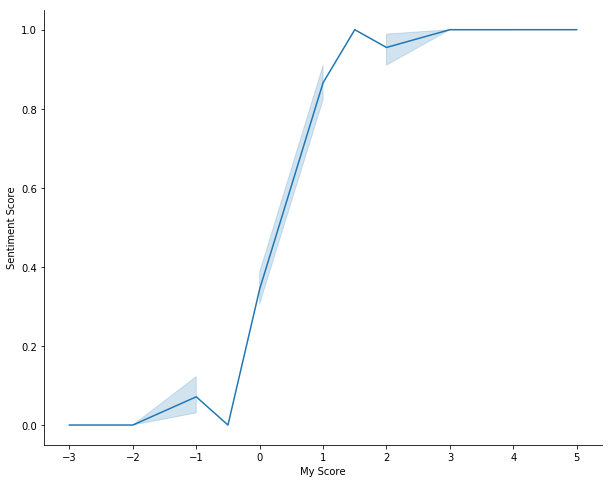

In [46]:
fig = plt.figure(figsize=(10,8))
sns.lineplot(x=reviews.sentiment_score, y=reviews.score)
sns.despine(fig=fig)
plt.xlabel("My Score")
plt.ylabel("Sentiment Score")
plt.show()

  * This is very promising!

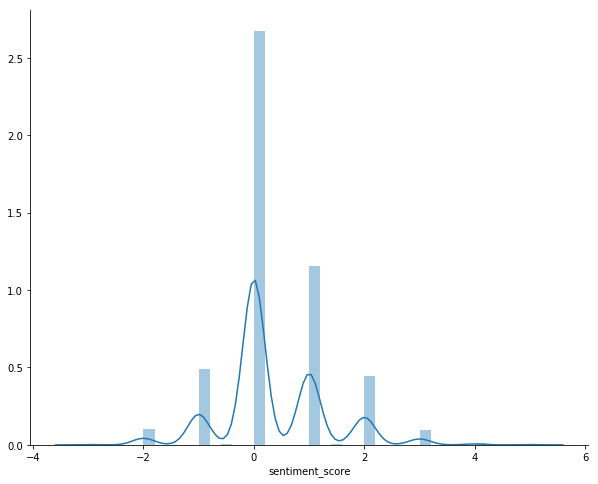

In [47]:
fig = plt.figure(figsize=(10,8))
sns.distplot(reviews.sentiment_score)
sns.despine(fig=fig)
plt.show()

In [8]:
x = [num/10 for num in range(-11,51)]
y = []
for num in x:
    y.append(reviews.query("sentiment_score <= {}".format(num)).score.mean())
data = pd.DataFrame([x, y]).transpose()
data.columns = ['x','y']

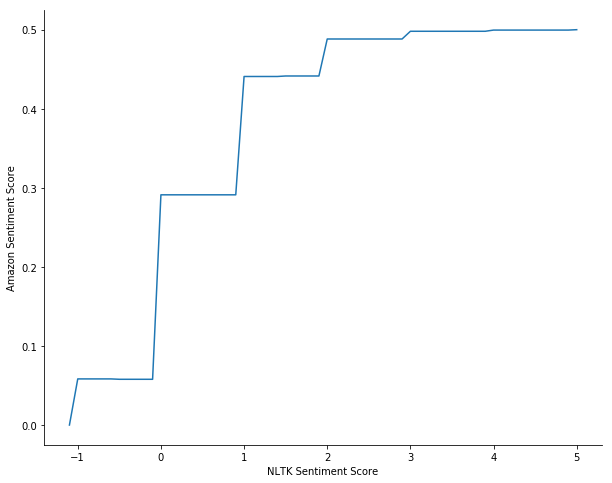

In [9]:
fig = plt.figure(figsize=(10,8))
sns.lineplot(x=x,y=y)
sns.despine(fig=fig)
plt.xlabel("NLTK Sentiment Score")
plt.ylabel("Amazon Sentiment Score")
plt.show()

So most are at 0, a few less than 0, whereas a lot more at 1 and same number of reviews scored 2 as scored -1.

In [14]:
# find out the point (my score) where score = 0.5
# looks to be slightly above 0
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score
score,,,,,
0,0.074,0.194,0.02,0.214,-0.195
1,0.156,0.124,0.01,0.084,0.877


# Models

## Model 1
*positive, negative keywords, has exclamation mark, is all caps and number of all caps words*

In [10]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )

In [11]:
def build_evaluate_model(reviews, features):
    data = reviews[features]
    target = reviews['score']
    # Instantiate our model and store it in a new variable.
    bnb = BernoulliNB()

    # Fit our model to the data.
    bnb.fit(data, target)

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)

    n = data.shape[0]
    # Display our results.
    print("Number of mislabeled points out of a total {} points : {}".format(
        n,
        (target != y_pred).sum()
    ))

    correct = (n - (target != y_pred).sum())/n * 100
    print("Accuracy: {}%".format(correct))
    
    cv = cross_val_score(bnb, data, target, cv=5)
    print(cv)
    print("cv average is = {:.2f}%".format(cv.mean()*100))
    
    cm = confusion_matrix(target, y_pred)
    print(cm)
    print("True Positive = {:.2f}%".format(cm[1,1]/10))
    print("False Positive = {:.2f}%".format(cm[0,1]/10))
    print("True Negative = {:.2f}%".format(cm[0,0]/10))
    print("False Negative = {:.2f}%".format(cm[1,0]/10))
    print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
    # sensitivity (recall) is the percentage of positives identified or TP/FN+TP
    print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

In [12]:
features = list(pos_words) + list(neg_words) + ["exclamation", "allcaps"]
build_evaluate_model(reviews, features)

Number of mislabeled points out of a total 1000 points : 327
Accuracy: 67.30000000000001%
[0.72  0.675 0.66  0.67  0.62 ]
cv average is = 66.90%
[[463  37]
 [290 210]]
True Positive = 21.00%
False Positive = 3.70%
True Negative = 46.30%
False Negative = 29.00%
sensitivity or hit rate is 42.00%
specificity or True Negative rate is 92.60%


## Model 2
*now include the number of all-cap words, and word pairs*

In [13]:
word_pairs = ['do not', 'no problem', 'the best', 'loved it','the best', 'the greatest','so good','so great', 'not good', 'not bad', 'really great','really bad', 'really good', "very good", 
          'not impressed','very impressive', 'well made', 'badly made', 'not great', 'too big', 'too small', 
          'very poor', 'not working','working good', "doesn't work", "didn't work", "doesn't fit", 
          "wouldn't recommend", 'would recommend', 'not nice', 'not working','not easy', 'not happy']

In [15]:
reviews.head()

,review,score,exclamation,single_quote,allcaps,num_capitalized_words,percent_capitalized_words,neg,neu,pos,...,not working,working good,doesn't work,didn't work,doesn't fit,wouldn't recommend,would recommend,not nice,not easy,not happy
0,So there is no way for me to plug it in here i...,0,False,False,False,0,0.0,0.120,0.880,0.000,...,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,False,False,False,0,0.0,0.000,0.100,0.900,...,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,0,0.0,0.000,0.423,0.577,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,True,False,False,2,1.0,0.287,0.713,0.000,...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,False,False,False,0,0.0,0.000,0.423,0.577,...,False,False,False,False,False,False,False,False,False,False


In [14]:
for pair in word_pairs:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(pair)] = reviews.review.str.contains(
       str(pair) ,
        case=False
    )

In [24]:
features = list(pos_words) + list(neg_words) + word_pairs + ["exclamation", "num_capitalized_words", "percent_capitalized_words"]
build_evaluate_model(reviews, features)

Number of mislabeled points out of a total 1000 points : 314
Accuracy: 68.60000000000001%
[0.725 0.68  0.7   0.685 0.635]
cv average is = 68.50%
[[464  36]
 [278 222]]
True Positive = 22.20%
False Positive = 3.60%
True Negative = 46.40%
False Negative = 27.80%
sensitivity or hit rate is 44.40%
specificity or True Negative rate is 92.80%


In [25]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_capitalized_words,percent_capitalized_words,neg,neu,pos,compound,sentiment_score,...,not working,working good,doesn't work,didn't work,doesn't fit,wouldn't recommend,would recommend,not nice,not easy,not happy
score,,,,,,,,,,,,,,,,,,,,,
0,0.074,0.194,0.02,0.214,0.142633,0.197146,0.752554,0.050308,-0.185386,-0.195,...,0.002,0.000,0.01,0.004,0.002,0.002,0.000,0.0,0.0,0.004
1,0.156,0.124,0.01,0.084,0.047067,0.012796,0.632062,0.355148,0.459773,0.877,...,0.000,0.002,0.00,0.000,0.000,0.000,0.012,0.0,0.0,0.000


**These numbers are great!**
While accuracy is good, we really want to get the true positive up and the false negative rate down though.

## Model 3
*This model will only use the sentiment score that we calculated*

In [28]:
build_evaluate_model(reviews, ["sentiment_score"])

Number of mislabeled points out of a total 1000 points : 226
Accuracy: 77.4%
[0.81  0.79  0.765 0.72  0.785]
cv average is = 77.40%
[[465  35]
 [191 309]]
True Positive = 30.90%
False Positive = 3.50%
True Negative = 46.50%
False Negative = 19.10%
sensitivity or hit rate is 61.80%
specificity or True Negative rate is 93.00%


## Model 4

*Now we will just be using the VADER sentiment scores and number of all caps words.*

In [26]:
features = ["neg", "neu", "pos", "compound"]
build_evaluate_model(reviews, features)

Number of mislabeled points out of a total 1000 points : 167
Accuracy: 83.3%
[0.825 0.875 0.815 0.8   0.85 ]
cv average is = 83.30%
[[423  77]
 [ 90 410]]
True Positive = 41.00%
False Positive = 7.70%
True Negative = 42.30%
False Negative = 9.00%
sensitivity or hit rate is 82.00%
specificity or True Negative rate is 84.60%


This model is the best yet! Notice false negative rate (FPR) is down (drastically) and the true positive rate (TPR) is double what it was in the previous model. Sensitivity and specificity are both relatively high (and the differential between the two is low).

## Model 5

*This model will use both the sentiment score that we computed as well as the scores that VADER gave us.*

In [29]:
features = ["neg", "neu", "pos", "compound", "sentiment_score"]
build_evaluate_model(reviews, features)

Number of mislabeled points out of a total 1000 points : 167
Accuracy: 83.3%
[0.825 0.87  0.815 0.785 0.85 ]
cv average is = 82.90%
[[423  77]
 [ 90 410]]
True Positive = 41.00%
False Positive = 7.70%
True Negative = 42.30%
False Negative = 9.00%
sensitivity or hit rate is 82.00%
specificity or True Negative rate is 84.60%


# Conclusions

We observed the best overall accuracy and sensitivity in **Model 4**, but a slightly higher specificity in **Model 5.** Our basic sentiment analysis that we manually performed is the best indicator of review sentiment, and if we further tweak the yaml files (pos/neg/inc/dec/inv.yml) we should be able to improve these rates further.  